In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import shap

/home/michal/mri/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cancer_types = {
    1: 'Oponiak',
    2: 'Glejak',
    3: 'Guz przysadki'
}

### Wczytanie danych procesowania
Dostępne dane składają się ze zdjęć zapisanych w formacie Matlab (.map). Każdy plik zawiera min. zdjęcie (image) oraz etykietę (label).

In [5]:
data_dir = 'data'
mri_images = []
labels = []

for file_name in os.listdir(data_dir):
    file_path = os.path.join(data_dir, file_name)
    file_mat = h5py.File(file_path, "r")
    image = np.array(file_mat['/cjdata/image'])
    image = Image.fromarray(image).resize((128, 128))
    mri_images.append(np.array(image))
    labels.append(file_mat['/cjdata/label'][0][0])

### Wizualizacja danych

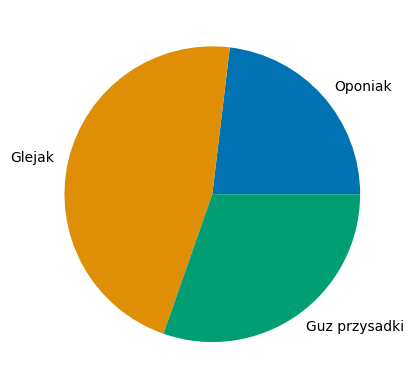

In [7]:
palette_color = sns.color_palette('colorblind')
unique_values, counts = np.unique(labels, return_counts=True)
plt.pie(counts, labels=list(cancer_types.values()), colors=palette_color)
plt.show()

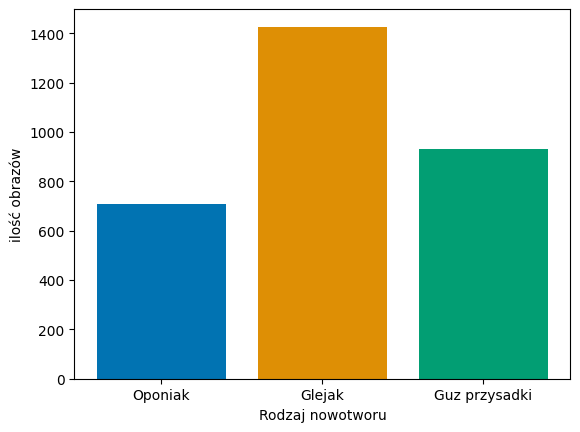

In [8]:
plt.bar(list(cancer_types.values()), counts, color=palette_color)
plt.xlabel('Rodzaj nowotworu')
plt.ylabel('ilość obrazów')
plt.show()

### Przykładowe zdjęcia

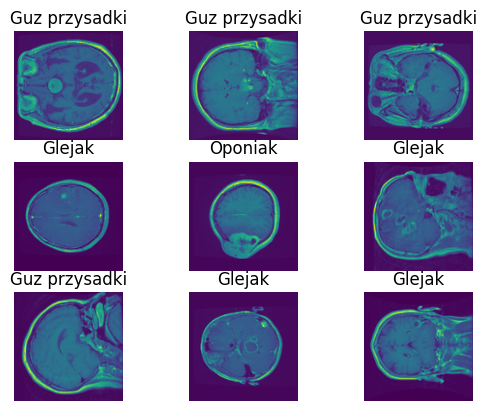

In [9]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(mri_images[i])
    plt.title(cancer_types[int(labels[i])])
    plt.axis("off")

### Podział danych na treningowe i testowe

In [6]:
mri_images = np.array(mri_images)
labels = np.array(labels)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(mri_images, labels, test_size=0.2, random_state=13)

### Klasyfikacja za pomocą Maszyny Wektorów Nośnych

In [14]:
# Do klasyfikacji za pomoca SVM konieczne będzie spłaszczenie danych wejściowych
X_train_flattened = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_flattened = X_test.reshape(X_test.shape[0], -1) / 255.0

In [15]:
X_train_flattened.shape

(2451, 16384)

In [12]:
svm_classifier = SVC(kernel='rbf')
svm_classifier.fit(X_train_flattened, y_train)
y_pred_svm = svm_classifier.predict(X_test_flattened)

In [13]:
accuracy = accuracy_score(y_test, y_pred_svm, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_svm, normalize = False)
precision = precision_score(y_test, y_pred_svm, average = 'weighted')
recall = recall_score(y_test, y_pred_svm, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8384991843393148
Accuracy count: 514.0
Precision: 0.8377155561551534
Recall: 0.8384991843393148


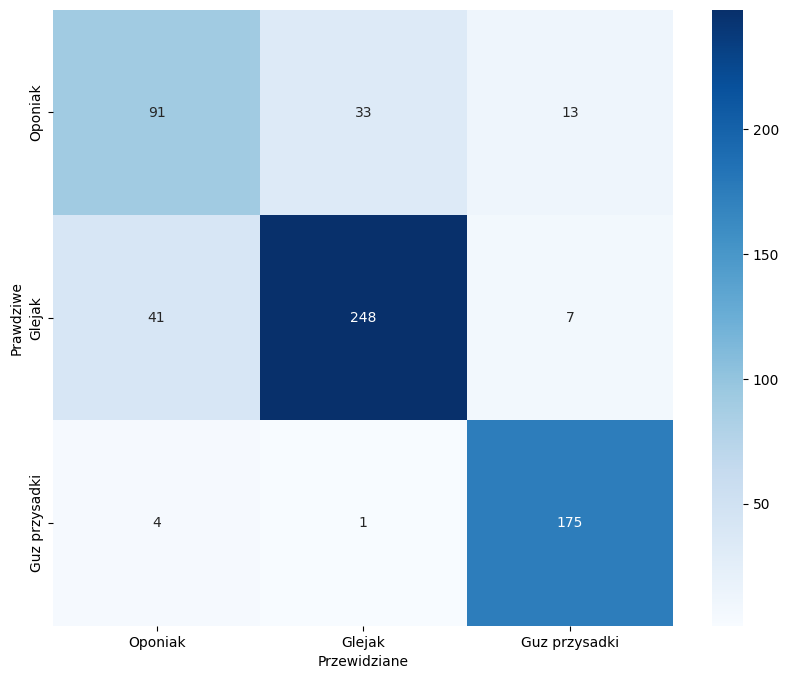

In [14]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer_types.values(), yticklabels=cancer_types.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [15]:
print(classification_report(y_test, y_pred_svm, target_names=cancer_types.values()))


               precision    recall  f1-score   support

      Oponiak       0.67      0.66      0.67       137
       Glejak       0.88      0.84      0.86       296
Guz przysadki       0.90      0.97      0.93       180

     accuracy                           0.84       613
    macro avg       0.82      0.82      0.82       613
 weighted avg       0.84      0.84      0.84       613



### Klasyfikacja za pomocą XGBoost

In [16]:
# Etykiety powinny być typu int oraz zaczynać się od 0
y_train = y_train.astype(int) - 1

In [17]:
xgb_classifier = XGBClassifier(objective='multi:softprob')
xgb_classifier.fit(X_train_flattened, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_flattened)

In [18]:
y_test = y_test.astype(int) - 1

In [19]:
accuracy = accuracy_score(y_test, y_pred_xgb, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_xgb, normalize = False)
precision = precision_score(y_test, y_pred_xgb, average = 'weighted')
recall = recall_score(y_test, y_pred_xgb, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9477977161500816
Accuracy count: 581.0
Precision: 0.950112646765394
Recall: 0.9477977161500816


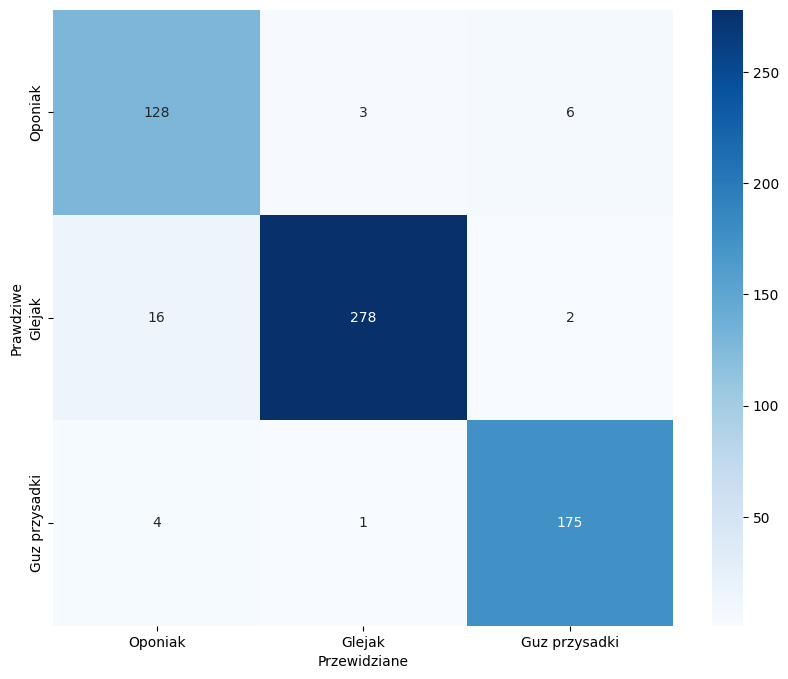

In [20]:
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer_types.values(), yticklabels=cancer_types.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [21]:
print(classification_report(y_test, y_pred_xgb, target_names=cancer_types.values()))


               precision    recall  f1-score   support

      Oponiak       0.86      0.93      0.90       137
       Glejak       0.99      0.94      0.96       296
Guz przysadki       0.96      0.97      0.96       180

     accuracy                           0.95       613
    macro avg       0.94      0.95      0.94       613
 weighted avg       0.95      0.95      0.95       613



### Klasyfikacja za pomocą Lasu Losowego

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=500)
rf_classifier.fit(X_train_flattened, y_train)
y_pred_rf = rf_classifier.predict(X_test_flattened)

In [23]:
accuracy = accuracy_score(y_test, y_pred_rf, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_rf, normalize = False)
precision = precision_score(y_test, y_pred_rf, average = 'weighted')
recall = recall_score(y_test, y_pred_rf, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9429037520391517
Accuracy count: 578.0
Precision: 0.9474403361019432
Recall: 0.9429037520391517


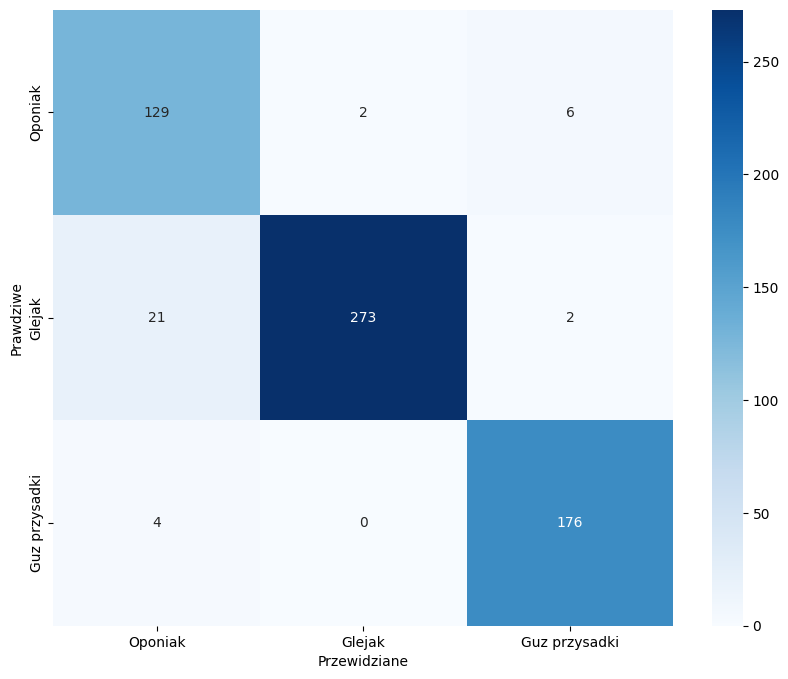

In [24]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer_types.values(), yticklabels=cancer_types.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [25]:
print(classification_report(y_test, y_pred_rf, target_names=cancer_types.values()))


               precision    recall  f1-score   support

      Oponiak       0.84      0.94      0.89       137
       Glejak       0.99      0.92      0.96       296
Guz przysadki       0.96      0.98      0.97       180

     accuracy                           0.94       613
    macro avg       0.93      0.95      0.94       613
 weighted avg       0.95      0.94      0.94       613



### Hiperparametryzacja

Co prawda najlepsze wyniki dla analizowanych danych dał XGBoost, ale ze względu na problemy z kompatybilnością XGBoosta z GridSearchem (https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags) hiperparamteryzację wykonamy dla Lasu losowego.

In [26]:
param_grid_rf = {
    'n_estimators': [500, 550, 600, 650, 700],
    'max_depth': [None, 30, 60, 90, 120],
    'min_samples_split': [2, 5, 8, 11, 14],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train_flattened, y_train)

print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
print("Best Cross-Validation Accuracy for RandomForest:", grid_search_rf.best_score_)

Best Parameters for RandomForest: {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 120}
Best Cross-Validation Accuracy for RandomForest: 0.9265605875152998


In [28]:
best_rf_model = grid_search_rf.best_estimator_
best_rf_model.fit(X_train_flattened, y_train)

RandomForestClassifier(max_depth=120, n_estimators=600, random_state=42)

In [29]:
y_pred_best_rf = best_rf_model.predict(X_test_flattened)

In [30]:
accuracy = accuracy_score(y_test, y_pred_best_rf, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_best_rf, normalize = False)
precision = precision_score(y_test, y_pred_best_rf, average = 'weighted')
recall = recall_score(y_test, y_pred_best_rf, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.9412724306688418
Accuracy count: 577.0
Precision: 0.9447802179115622
Recall: 0.9412724306688418


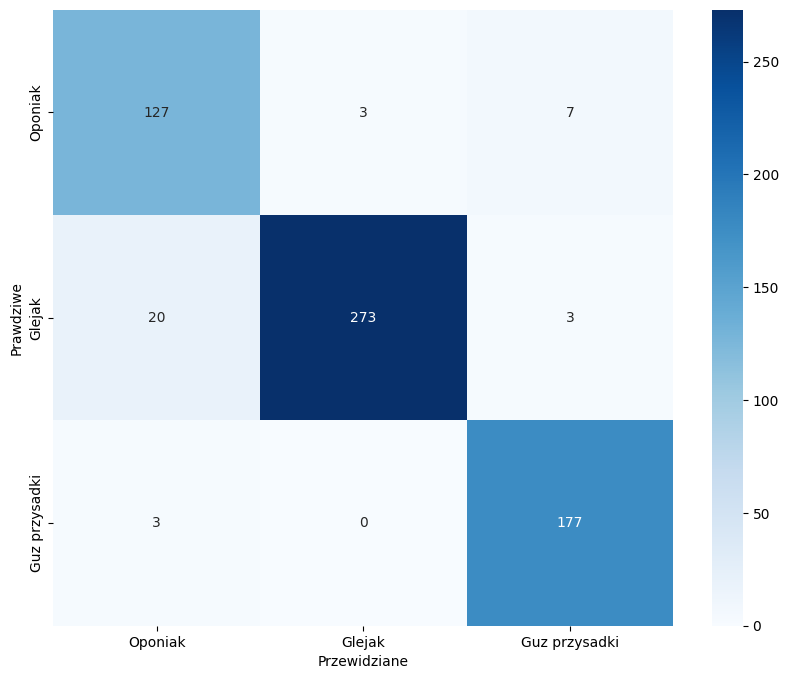

In [31]:
cm = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cancer_types.values(), yticklabels=cancer_types.values())
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [32]:
print(classification_report(y_test, y_pred_rf, target_names=cancer_types.values()))

               precision    recall  f1-score   support

      Oponiak       0.84      0.94      0.89       137
       Glejak       0.99      0.92      0.96       296
Guz przysadki       0.96      0.98      0.97       180

     accuracy                           0.94       613
    macro avg       0.93      0.95      0.94       613
 weighted avg       0.95      0.94      0.94       613



In [35]:
# Zapis modelu do pliku
with open("model_best.pkl", "wb") as f:
    pickle.dump(best_rf_model, f)

### XAI

In [12]:
# Odczyt modelu z pliku
with open("model_best.pkl", "rb") as f:
    loaded_model = pickle.load(f)

In [59]:
explainer = shap.Explainer(loaded_model, X_test_flattened)

In [60]:
shap_values = explainer(X_test_flattened, check_additivity=False)


100%|===================| 1838/1839 [02:11<00:00]        

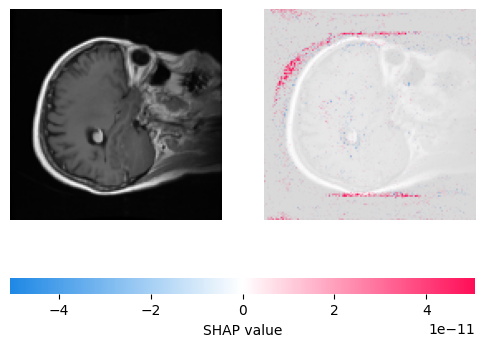

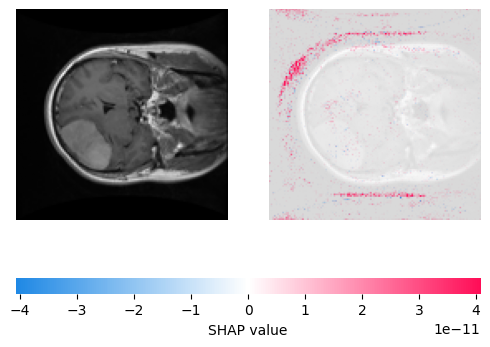

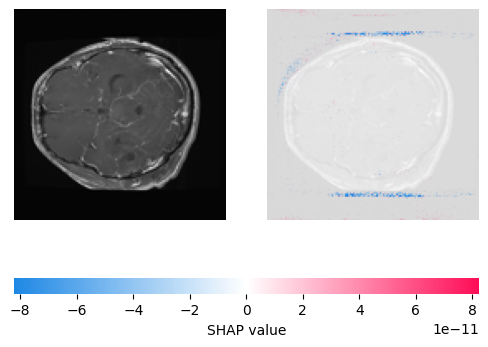

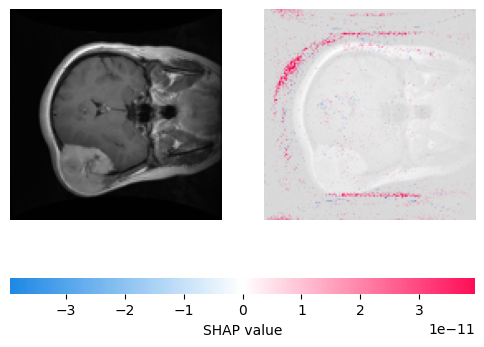

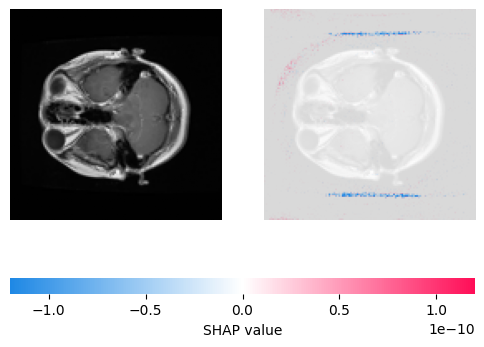

In [67]:
sample_index = 19
for i in range(0, 100, 20):
    shap.image_plot(shap_values[i].values.reshape(128, 128, 3), X_test[i])


#### Wnioski
Zastosowanie SHAPa prowadzi do mrożącej krew w żyłach konkluzji, że pomimo iż wytrenowane modele zdają się mieć dobrą dokładność, w rzeczywistości rozpoznają rózne typy nowotworów na podstawie cech które są nieistotne z punktu widzenia realnej diagnozy.

### Zastosowanie Histogramu Gradientów (HOG) do ekstrakcji cech obrazów

In [8]:
from skimage.feature import hog
from skimage.transform import resize

In [9]:
def extract_heatures_with_hog(images):
    features = []
    for img in images:
        hog_features = hog(img, pixels_per_cell=(4,4), cells_per_block=(2,2), feature_vector=True)
        features.append(hog_features)
    return np.array(features)

In [10]:
X_train_hog = extract_heatures_with_hog(X_train)
X_test_hog = extract_heatures_with_hog(X_test)

In [11]:
X_train_hog_flattened = X_train_hog.reshape(X_train_hog.shape[0], -1) / 255.0
X_test_hog_flattened = X_test_hog.reshape(X_test_hog.shape[0], -1) / 255.0

In [12]:
rf_classifier = RandomForestClassifier(n_estimators=500)
rf_classifier.fit(X_train_hog_flattened, y_train)
y_pred_rf = rf_classifier.predict(X_test_hog_flattened)

In [13]:
accuracy = accuracy_score(y_test, y_pred_rf, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_rf, normalize = False)
precision = precision_score(y_test, y_pred_rf, average = 'weighted')
recall = recall_score(y_test, y_pred_rf, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.8694942903752039
Accuracy count: 533.0
Precision: 0.8667494750854532
Recall: 0.8694942903752039


: 

In [ ]:
explainer = shap.Explainer(rf_classifier, X_test_hog_flattened)
shap_values = explainer(X_test_hog_flattened, check_additivity=False)

In [60]:
shap_values_selected = shap_values.values[0, :, 1]

In [61]:
shap_values_selected.shape

(8100,)

In [62]:
_, hog_visualization = hog(X_test[100], pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True)
print("Kształt wizualizacji HOG:", hog_visualization.shape)  # np. (16,16) lub (32,32)

Kształt wizualizacji HOG: (128, 128)


In [63]:
shap_values_reshaped = shap_values_selected.reshape(30, 30, 9)  # Dopasowanie do bloków HOG
print("Nowy kształt SHAP:", shap_values_reshaped.shape)

Nowy kształt SHAP: (30, 30, 9)


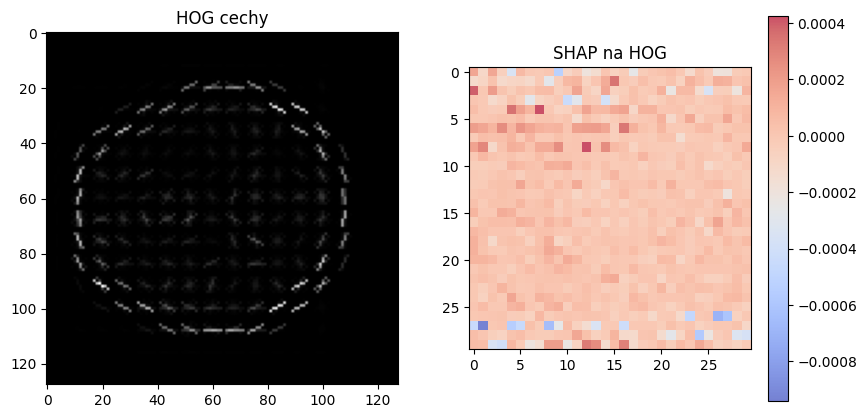

In [64]:
shap_mean = np.mean(shap_values_reshaped, axis=-1)  # Redukcja do (30,30)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("HOG cechy")
plt.imshow(hog_visualization, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("SHAP na HOG")
plt.imshow(shap_mean, cmap="coolwarm", alpha=0.7)
plt.colorbar()

plt.show()